<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Train/Test Split and Bias and Variance

_Authors: Joseph Nelson (DC), Kevin Markham (DC)_

---

<a id="learning-objectives"></a>
<a id="learning-objectives"></a>
<a id="learning-objectives"></a>
### Learning Objectives
- Define error due to bias and error due to variance.
- Identify the bias-variance trade-off.
- Describe what overfitting and underfitting means in the context of model building.
- Explain problems associated with over- and underfitting.
- Grasp why train/test split is necessary.
- Explore k-folds, LOOCV, and three split methods.

<a id="bias-and-variance-trade-off"></a>
# Section 1: Bias and Variance Trade-Off
---

The **bias-variance tradeoff** is widely used in machine learning as a conceptual way of comparing and contrasting different models. We only have a few methods that are able to compare all machine learning models. The others are more mathematical.

**Bias** is error stemming from incorrect model assumptions.
- Example: Assuming data is linear when it has a more complicated structure.

**Variance** is error stemming from being overly sensitive from changes to the training data.
- Example: Using the training set exactly (e.g. 1-NN) for a model results in a completely different model -- even if the training set differs only slightly.


As model complexity **increases**:
- Bias **decreases**. (The model can more accurately model complex structure in data.)
- Variance **increases**. (The model identifies more complex structures, making it more sensitive to small changes in the training data.)

<a id="bias-variance"></a>
### Bias? Variance?

**Conceptual Definitions**
- **Bias**: How close are predictions to the actual values?
  - Roughly, whether or not our model aims on target.
  - If the model cannot represent the data's structure, our predictions could be consistent, but will not be accurate.
- **Variance**: How variable are our predictions?
  - Roughly, whether or not our model is reliable.
  - We will make slightly different predictions given slightly different training sets.

![](./assets/biasVsVarianceImage.png)

- Visually, we are building a model where the bulls-eye is the goal.
- Each individual hit is one prediction based on our model.
- Critically, the success of our model (low variance, low bias) depends on the training data present.

<a id="exploring-the-bias-variance-tradeoff"></a>
### Exploring the Bias-Variance Trade-Off

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Allow plots to appear in the notebook.
%matplotlib inline

<a id="brain-and-body-weight-mammal-dataset"></a>
### Brain and Body Weight Mammal Data Set

This is a [data set](http://people.sc.fsu.edu/~jburkardt/datasets/regression/x01.txt) of the average weight of the body (in kg) and the brain (in g) for 62 mammal species. We'll use this dataset to investigate bias vs. variance. Let's read it into Pandas and take a quick look:

In [2]:
path = 'data/mammals.txt'
cols = ['brain','body']
mammals = pd.read_table(path, sep='\t', names=cols, header=0)
mammals.head()

,brain,body
0,3.385,44.5
1,0.480,15.5
2,1.350,8.1
3,465.000,423.0
4,36.330,119.5


In [3]:
mammals.describe()

,brain,body
count,62.000000,62.000000
mean,198.789984,283.134194
std,899.158011,930.278942
min,0.005000,0.140000
25%,0.600000,4.250000
50%,3.342500,17.250000
75%,48.202500,166.000000
max,6654.000000,5712.000000


We're going to focus on a smaller subset in which the body weight is less than 200 kg.

In [4]:
# Only keep rows in which the body weight is less than 200 kg.
mammals = mammals[mammals.body < 200]
mammals.shape

(51, 2)

We're now going to pretend that there are only 51 mammal species in existence. In other words, we are pretending that this is the entire data set of brain and body weights for **every known mammal species**.

Let's create a scatterplot (using [Seaborn](http://stanford.edu/~mwaskom/software/seaborn/)) to visualize the relationship between brain and body weight:

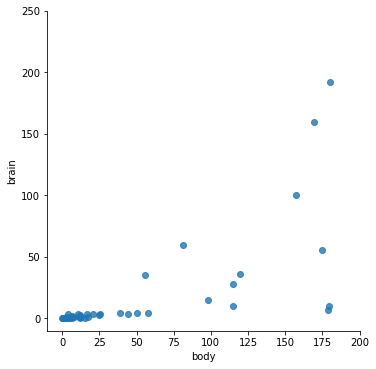

In [5]:
sns.lmplot(x='body', y='brain', data=mammals, ci=None, fit_reg=False);
plt.xlim(-10, 200);
plt.ylim(-10, 250);

There appears to be a relationship between brain and body weight for mammals.

<a id="making-a-prediction"></a>
### Making a Prediction

Now let's pretend that a **new mammal species** is discovered. We measure the body weight of every member of this species we can find and calculate an **average body weight of 100 kgs**. We want to **predict the average brain weight** of this species (rather than measuring it directly). How might we do this?

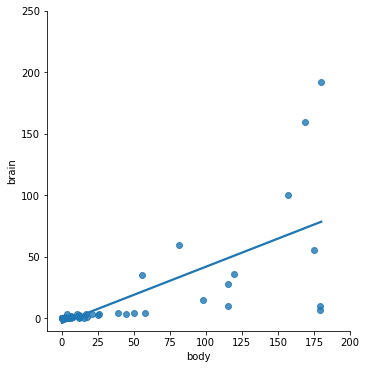

In [6]:
sns.lmplot(x='body', y='brain', data=mammals, ci=None);
plt.xlim(-10, 200);
plt.ylim(-10, 250);

We drew a straight line that appears to best capture the relationship between brain and body weight. So, we might predict that our new species has a brain weight of about 45 g, as that's the approximate y value when x=100.

This is known as a "linear model" or a "linear regression model."

<a id="making-a-prediction-from-a-sample"></a>
## Making a Prediction From a Sample

Earlier, we assumed that this dataset contained every known mammal species. That's very convenient, but **in the real world, all you ever have is a sample of data**. This may sound like a contentious statement, but the point of machine learning is to generalize from a sample to the population. If you already have data for the entire population, then you have no need for machine learning -- you can apply statistics directly and get optimal answers!

Here, a more realistic situation would be to only have brain and body weights for (let's say) half of the 51 known mammals.

When that new mammal species (with a body weight of 100 kg) is discovered, we still want to make an accurate prediction for its brain weight, but this task might be more difficult, as we don't have all of the data we would ideally like to have.

Let's simulate this situation by assigning each of the 51 observations to **either universe 1 or universe 2**:

In [7]:
# Set a random seed for reproducibility.
np.random.seed(12342)

# Randomly assign every observation to either universe 1 or universe 2.
mammals['zoologist'] = np.random.randint(1, 3, len(mammals))
mammals.head()

,brain,body,zoologist
0,3.385,44.5,1
1,0.480,15.5,2
2,1.350,8.1,2
4,36.330,119.5,2
5,27.660,115.0,2


**Important:** We only live in one of the two universes. Both universes have 51 known mammal species, but each universe knows the brain and body weight for different species.

We can now tell Seaborn to create two plots in which the left plot only uses the data from **universe 1** and the right plot only uses the data from **universe 2**:

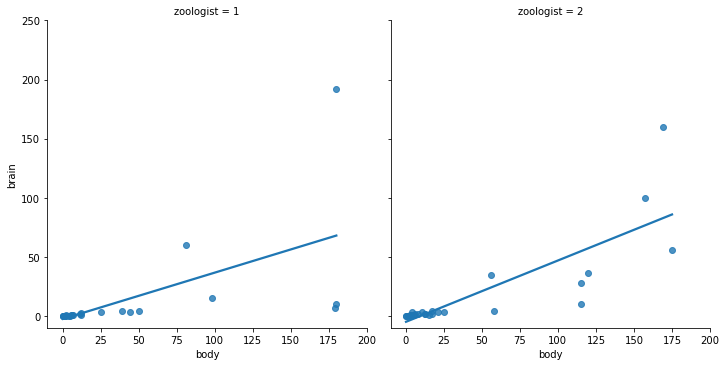

In [8]:
# col='universe' subsets the data by universe and creates two separate plots.
sns.lmplot(x='body', y='brain', data=mammals, ci=None, col='zoologist');
plt.xlim(-10, 200);
plt.ylim(-10, 250);

The line looks pretty similar between the two plots, despite the fact that they used separate samples of data. In both cases, we would predict a brain weight of about 45 g.

It's easier to see the degree of similarity by placing them on the same plot:

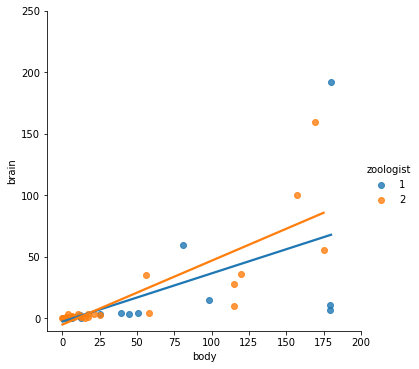

In [175]:
# hue='universe' subsets the data by universe and creates a single plot.
sns.lmplot(x='body', y='brain', data=mammals, ci=None, hue='zoologist');
plt.xlim(-10, 200);
plt.ylim(-10, 250);

So, what was the point of this exercise? This was a visual demonstration of a high-bias, low-variance model.

- It's **high bias** because it doesn't fit the data particularly well.
- It's **low variance** because it doesn't change much depending on which observations happen to be available in that universe.

<a id="lets-try-something-completely-different"></a>
### Let's Try Something Completely Different

What would a **low bias, high variance** model look like? Let's try polynomial regression with an eighth-order polynomial.

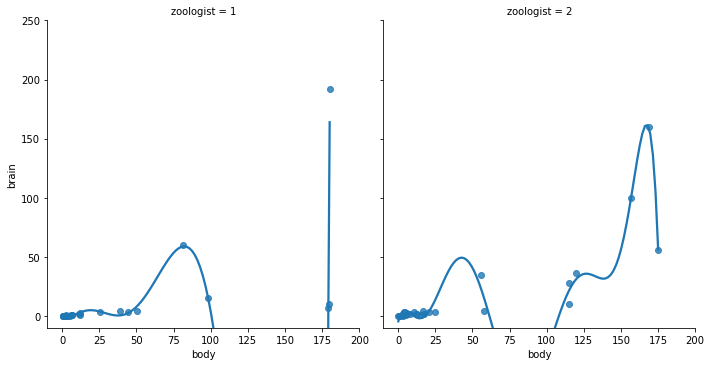

In [176]:
sns.lmplot(x='body', y='brain', data=mammals, ci=None, col='zoologist', order=8);
plt.xlim(-10, 200);
plt.ylim(-10, 250);

- It's **low bias** because the models match the data effectively.
- It's **high variance** because the models are widely different, depending on which observations happen to be available in that universe. (For a body weight of 100 kg, the brain weight prediction would be 40 kg in one universe and 0 kg in the other!)

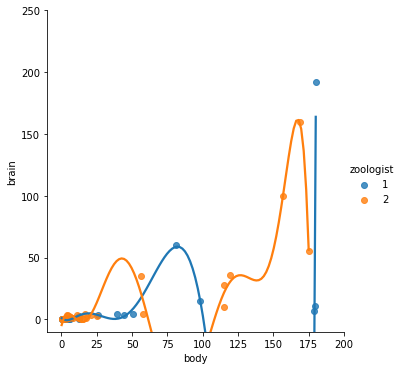

In [177]:
sns.lmplot(x='body', y='brain', data=mammals, ci=None, hue='zoologist', order=8);
plt.xlim(-10, 200);
plt.ylim(-10, 250);

<a id="balancing-bias-and-variance"></a>
## Balancing Bias and Variance
Can we find a middle ground?

Perhaps we can create a model that has **less bias than the linear model** and **less variance than the eighth order polynomial**?

Let's try a second order polynomial instead:

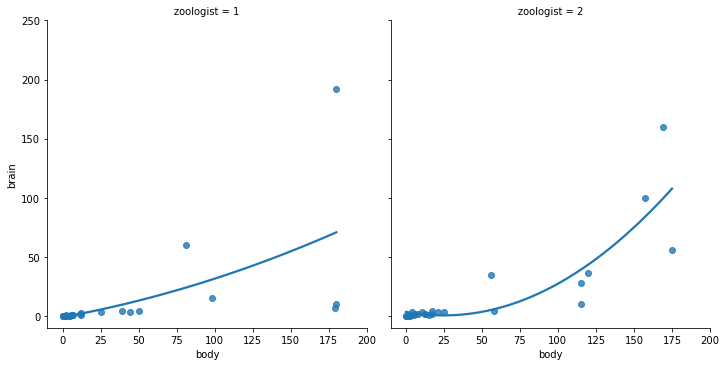

In [178]:
sns.lmplot(x='body', y='brain', data=mammals, ci=None, col='zoologist', order=2);
plt.xlim(-10, 200);
plt.ylim(-10, 250);

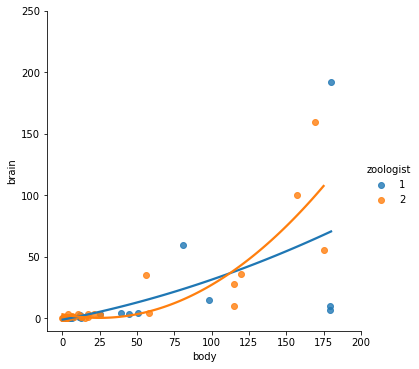

In [179]:
sns.lmplot(x='body', y='brain', data=mammals, ci=None, hue='zoologist', order=2);
plt.xlim(-10, 200);
plt.ylim(-10, 250);

This seems better. In both the left and right plots, **it fits the data well, but not too well**.

This is the essence of the **bias-variance trade-off**: You are seeking a model that appropriately balances bias and variance and thus will generalize to new data (known as "out-of-sample" data).

We want a model that best balances bias and variance. It
should match our training data well (moderate bias) yet be low variance for out-of-sample data (moderate variance).

- Training error as a function of
complexity.
- Question: Why do we even
care about variance if we
know we can generate a
more accurate model with
higher complexity?

### Can we obtain a zero-bias, zero-variance model?

No! If there is any noise in the data-generating process, then a zero-variance model would not be learning from the data. Additionally, a model only has zero bias if the true relationship between the target and the features is hard-coded into it. If that were the case, you wouldn't be doing machine learning -- it would be similar to trying to predict today's temperature by using today's temperature!

---

<a id="train-test-split"></a>
## Section 2: Train-test-split

For the rest of the lab, we will look at three evaluation procedures for predicting model out-of-sample accuracy:

1. **Train on the entire dataset** should never be done to estimate model accuracy on out-of-sample data! After all, training error can be made arbitrarily small or large. You might train on the entire dataset as the very last step when a model is chosen, hoping to make the final model as accurate as possible. Or, you could use this to estimate the degree of overfitting.
2. **Train-test-split** is useful if cross-validation is not practical (e.g. it takes too long to train). It is also useful for computing a quick confusion matrix. You could also use this as a final step after the model is finalized (often called evaluating the model against a **validation set**).
3. **Cross-validation** is the gold standard for estimating accuracy and comparing accuracy across models.
4. **Three-way split** combines cross-validation and the train-test-split. It takes an initial split to be used as a final validation set, then uses cross-validation on the rest.

We run into a problem when powerful models can perfectly fit the data on which they are trained. These models are **low bias** and **high variance**. However, we can't observe the variance of a model directly, because we only know how it fits the data we have rather than all potential samples.

**Solution:** Create a procedure that **estimates** how well a model is likely to perform on out-of-sample data and use that to choose between models.


**Note:** These procedures can be used with **any machine learning model**.


**The Holdout Method: Train/Test Split**
- **Training set**: Used to train the classifier.
- **Testing set**: Used to estimate the error rate of the trained classifier.
- **Advantages**: Fast, simple, computationally inexpensive.
- **Disadvantages** Eliminates data, imperfectly splits.

<a id="evaluation-procedure--train-and-test-on-the-entire-dataset-do-not-do-this"></a>
### Evaluation Procedure #1: Train and Test on the Entire Data Set (Do Not Do This)

1. Train the model on the **entire data set**.
2. Test the model on the **same data set** and evaluate how well we did by comparing the **predicted** response values with the **true** response values.

#### Load in the Boston data.

In [180]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston

boston = load_boston()

In [181]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

#### Create X and y variable to stores the feature matrix and response from the Boston data.

In [182]:
boston.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [183]:
# Create a DataFrame for both parts of data; don't forget to assign column names.
X = pd.DataFrame(boston.data, columns=boston.feature_names)

#Median value of owner-occupied homes so is the target
y = pd.DataFrame(boston.target, columns=['MEDV'])

#### Concatenate y and X, then overwrite the Boston variable.

In [184]:
boston = pd.concat([y, X], axis=1)

#### Perform basic EDA to make sure the data are in order.

In [185]:
boston.isnull().sum()

MEDV       0
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

In [186]:
boston.head()

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,24.0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,21.6,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,34.7,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,33.4,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,36.2,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [187]:
boston.dtypes

MEDV       float64
CRIM       float64
ZN         float64
INDUS      float64
CHAS       float64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD        float64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
dtype: object

In [188]:
boston.describe()

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,22.532806,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,9.197104,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,5.000000,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,17.025000,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,21.200000,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,25.000000,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,50.000000,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


#### Prepare a feature matrix (X) and response (y)  for scikit-learn.

In [189]:
# create feature matrix (X)
feature_cols = boston.columns.drop(['MEDV'])
X = boston[feature_cols]

# create response vector (y)
y = boston.MEDV

#### Import linear regression, instantiate, fit, and preview predictions.

In [190]:
# Import the class.
from sklearn.linear_model import LinearRegression

# Instantiate the model.
lr = LinearRegression()

# Train the model on the entire data set.
lr.fit(X, y)

LinearRegression()

#### Store the predicted response values.

In [191]:
y_pred = lr.predict(X)

To evaluate a model, we also need an **evaluation metric:**

- A numeric calculation used to **quantify** the performance of a model.
- The appropriate metric depends on the **goals** of your problem.

The most common choices for regression problems are:

- **R-squared**: The percentage of variation explained by the model (a "reward function," as higher is better).
- **Mean squared error**: The average squared distance between the prediction and the correct answer (a "loss function," as lower is better).

In this case, we'll use mean squared error because it is more interpretable in a predictive context.

#### Compute mean squared error using a function from `metrics`.

In [192]:
print('R-Squared: ' + str(lr.score(X,y)))

from sklearn import metrics

print('MSE: ' + str(metrics.mean_squared_error(y, y_pred)))

R-Squared: 0.7406426641094095
MSE: 21.894831181729202


This is known as the **training mean squared error** because we are evaluating the model based on the same data we used to train the model.

<a id="problems-with-training-and-testing-on-the-same-data"></a>
### Problems With Training and Testing on the Same Data

- Our goal is to estimate likely performance of a model on **out-of-sample data**.
- But, maximizing the training mean squared error rewards **overly complex models** that won't necessarily generalize.
- Unnecessarily complex models **overfit** the training data.
    - They will do well when tested using the in-sample data.
    - They may do poorly with out-of-sample data.
    - They learn the "noise" in the data rather than the "signal."
    - From Quora: [What is an intuitive explanation of overfitting?](http://www.quora.com/What-is-an-intuitive-explanation-of-overfitting/answer/Jessica-Su)

**Thus, the training MSE is not a good estimate of the out-of-sample MSE.**

<a id="evaluation-procedure--traintest-split"></a>
### Evaluation procedure #2: Train/Test Split

1. Split the data set into two pieces: a **training set** and a **testing set**.
2. Train the model on the **training set**.
3. Test the model on the **testing set** and evaluate how well we did.

Often a good rule-of-thumb is 70% training/30% test, but this can vary based on the size of your dataset. For example, with a small dataset you would need to use as much training data as possible (in return, your test accuracy will be more variable).

What does this accomplish?

- Models can be trained and tested on **different data** (We treat testing data like out-of-sample data).
- Response values are known for the testing set and thus **predictions can be evaluated**.

This is known as the **testing mean squared error** because we are evaluating the model on an independent "test set" that was not used during model training.

**The testing MSE is a better estimate of out-of-sample performance than the training MSE.**

## Exercise

#### 1) Build a linear regression model for the Boston housing dataset using train_test_split. Initially make the split 70/30 and evaluate the model by calculating the MSE

In [193]:
from sklearn.model_selection import train_test_split

In [194]:
# A:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7)
print(X_train.shape)
print(X_test.shape)
X_test.head()

(354, 13)
(152, 13)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
171,2.31390,0.0,19.58,0.0,0.605,5.880,97.3,2.3887,5.0,403.0,14.7,348.13,12.03
53,0.04981,21.0,5.64,0.0,0.439,5.998,21.4,6.8147,4.0,243.0,16.8,396.90,8.43
60,0.14932,25.0,5.13,0.0,0.453,5.741,66.2,7.2254,8.0,284.0,19.7,395.11,13.15
246,0.33983,22.0,5.86,0.0,0.431,6.108,34.9,8.0555,7.0,330.0,19.1,390.18,9.16
442,5.66637,0.0,18.10,0.0,0.740,6.219,100.0,2.0048,24.0,666.0,20.2,395.69,16.59


In [195]:
#lr_TesetTrainSplit
lr_tts=LinearRegression()

#Fit our training data into our model
lr_tts.fit(X_train,y_train)

print('Training Set: ' +str(lr.score(X_train,y_train)))
print('Testing Set: ' +str(lr.score(X_test,y_test)))

#make your y predictions, based on the test data
y_pred=lr_tts.predict(X_test)

#compare predictions with test
print('Test MSE: ' + str(metrics.mean_squared_error(y_pred,y_test)))

Training Set: 0.700197837409062
Testing Set: 0.8381770576800409
Test MSE: 14.207559384335935


#### Try changing the `train_size` parameter to see what effect this has on your model

#### 2) Explore the `random_state` Parameter

The `random_state` is a pseudo-random number that allows us to reproduce our results every time we run them. However, it makes it impossible to predict what are exact results will be if we chose a new `random_state`.

`random_state` is very useful for testing that your model was made correctly since it provides you with the same split each time. However, **make sure you remove it if you are testing for model variability!**

In [196]:
# WITHOUT a random_state parameter:
#  (If you run this code several times, you get different results!)
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Print the first element of each object.
print(X_train.head(1))

        CRIM   ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
227  0.41238  0.0    6.2   0.0  0.504  7.163  79.9  3.2157  8.0  307.0   

     PTRATIO       B  LSTAT  
227     17.4  372.08   6.36  


In [197]:
# WITH a random_state parameter:
#  (Same split every time! Note you can change the random state to any integer.)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Print the first element of each object.
print(X_train.head(1))
print(X_test.head(1))
print(y_train.head(1))
print(y_test.head(1))

        CRIM   ZN  INDUS  CHAS    NOX    RM   AGE     DIS  RAD    TAX  \
502  0.04527  0.0  11.93   0.0  0.573  6.12  76.7  2.2875  1.0  273.0   

     PTRATIO      B  LSTAT  
502     21.0  396.9   9.08  
        CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
307  0.04932  33.0   2.18   0.0  0.472  6.849  70.3  3.1827  7.0  222.0   

     PTRATIO      B  LSTAT  
307     18.4  396.9   7.53  
502    20.6
Name: MEDV, dtype: float64
307    28.2
Name: MEDV, dtype: float64


#### 3) Go back to Step 1 and try adding new variables and transformations. Try using StandardScaler.

- **Training error**: Decreases as model complexity increases (lower value of k).
- **Testing error**: Is minimized at the optimum model complexity.

<a id="k-folds-cross-validation"></a>
## Section 3: K-Folds Cross-Validation
---

Train/test split provides us with helpful tool, but it's a shame that we are tossing out a large chunk of our data for testing purposes.

**How can we use the maximum amount of our data points while still ensuring model integrity?**

1. Split our data into a number of different pieces (folds).
2. Train using `k-1` folds for training and a different fold for testing.
3. Average our model against EACH of those iterations.
4. Choose our model and TEST it against the final fold.
5. Average all test accuracies to get the estimated out-of-sample accuracy.

Although this may sound complicated, we are just training the model on k separate train-test-splits, then taking the average of the resulting test accuracies!

![](./assets/cross_validation_diagram.png)

<a id="intro-to-cross-validation-with-the-boston-data"></a>
### Exercise: Cross-Validation With the Boston Data

#### 1) Run the code below for a demonstration of how cross validation works

In [116]:
from sklearn import model_selection
kf = model_selection.KFold(n_splits=5, shuffle=True)

mse_values = []
scores = []
n = 0

print("~~~~ CROSS VALIDATION each fold ~~~~")
for train_index, test_index in kf.split(X, y):
    lr = LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lr.predict(X.iloc[test_index])))
    scores.append(lr.score(X, y))
    
    n += 1
    
    print('Model {}'.format(n))
    print('MSE: {}'.format(mse_values[n-1]))
    print('R2: {}\n'.format(scores[n-1]))


print("~~~~ SUMMARY OF CROSS VALIDATION ~~~~")
print('Mean of MSE for all folds: {}'.format(np.mean(mse_values)))
print('Mean of R2 for all folds: {}'.format(np.mean(scores)))

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 19.340908937838478
R2: 0.7383241757030614

Model 2
MSE: 31.351936181854583
R2: 0.7369977126423637

Model 3
MSE: 20.386981424556488
R2: 0.7384957723541627

Model 4
MSE: 23.53916924182759
R2: 0.7364557870247278

Model 5
MSE: 26.599232125699164
R2: 0.7372580566739886

~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 24.243645582355263
Mean of R2 for all folds: 0.7375063008796608


#### 2) Create a cross-validation with five folds and return the score for each model, and the average score

In [125]:
from sklearn.model_selection import cross_val_score, KFold

In [198]:
# A:
lr=LinearRegression()

print(cross_val_score(lr,X,y))

print(cross_val_score(lr,X,y).mean())


[ 0.63919994  0.71386698  0.58702344  0.07923081 -0.25294154]
0.3532759243958823


#### Extend: Write a loop that cycles through 2 to 10 folds, calculating the average score for each. Which number of folds produces the best average score?

In [204]:
# A:

for z in [2,3,4,5,6,7,8,9,10]:
    kf = model_selection.KFold(n_splits=z, shuffle=False)

    mse_values = []
    scores = []
    n = 0

    print("~~~~ CROSS VALIDATION each fold ~~~~")
    for train_index, test_index in kf.split(X, y):
 
        lr = LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])

        mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lr.predict(X.iloc[test_index])))
        scores.append(lr.score(X, y))

        #print('Model {}'.format(n))
        #print('MSE: {}'.format(mse_values[n-1]))
        #print('R2: {}\n'.format(scores[n-1]))
    print(z)
    print('Mean of MSE for all folds: {}'.format(np.mean(mse_values)))
    print('Mean of R2 for all folds: {}'.format(np.mean(scores)))
    print(str(z) + ' folds average score: ' + str(cross_val_score(lr,X,y,cv=kf).mean()))
    

~~~~ CROSS VALIDATION each fold ~~~~
2
Mean of MSE for all folds: 165.32777820869637
Mean of R2 for all folds: -0.08068620705751556
2 folds average score: -0.822882772144772
~~~~ CROSS VALIDATION each fold ~~~~
3
Mean of MSE for all folds: 169.00831238146108
Mean of R2 for all folds: 0.18789290605995168
3 folds average score: -1.5841985220997792
~~~~ CROSS VALIDATION each fold ~~~~
4
Mean of MSE for all folds: 42.36580749185354
Mean of R2 for all folds: 0.6952749304405004
4 folds average score: 0.11405301290098091
~~~~ CROSS VALIDATION each fold ~~~~
5
Mean of MSE for all folds: 37.13180746769895
Mean of R2 for all folds: 0.7156683198902885
5 folds average score: 0.3532759243958823
~~~~ CROSS VALIDATION each fold ~~~~
6
Mean of MSE for all folds: 39.11713630106426
Mean of R2 for all folds: 0.7180091741021171
6 folds average score: 0.4001944881138572
~~~~ CROSS VALIDATION each fold ~~~~
7
Mean of MSE for all folds: 37.28723086835309
Mean of R2 for all folds: 0.7234097603867632
7 folds a

In [201]:
for n in range(2,11):
    kf=KFold(n_splits=n,shuffle=False)
    print(str(n) + ' folds average score: ' + str(cross_val_score(lr,X,y,cv=kf).mean()))

2 folds average score: -0.822882772144772
3 folds average score: -1.5841985220997792
4 folds average score: 0.11405301290098091
5 folds average score: 0.3532759243958823
6 folds average score: 0.4001944881138572
7 folds average score: 0.4505944247136283
8 folds average score: 0.35410905269169946
9 folds average score: 0.38127694704772225
10 folds average score: 0.20252899006055775


While the cross-validated approach here generated more overall error, which of the two approaches would predict new data more accurately — the single model or the cross-validated, averaged one? Why?



In [153]:
# A:


ValueError: plot_confusion_matrix only supports classifiers

<a id="three-way-data-split"></a>
## Section 4: Three-Way Data Split
---

The most common workflow is actually a combination of train/test split and cross-validation. We take a train/test split on our data right away and try not spend a lot of time using the testing data set. Instead, we take our training data and tune our models using cross-validation. When we think we are done, we do one last test on the testing data to make sure we haven't accidently overfit to our training data.

**If you tune hyperparameters via cross-validation, you should never use cross-validation on the same dataset to estimate OOS accuracy!** Using cross-validation in this way, the entire dataset was used to tune hyperparameters. So, this invalidates our condition above -- where we assumed the test set is a pretend "out-of-sample" dataset that was not used to train our model! So, we would expect the accuracy on this test set to be artificially inflated as compared to actual "out-of-sample" data.

Even with good evaluation procedures, it is incredible easy to overfit our models by including features that will not be available during production or leak information about our testing data in other ways.

![](./assets/Train-Test-Split-CV.png)

- If model selection and true error estimates are to be computed simultaneously, three disjointed data sets are best.
    - **Training set**: A set of examples used for learning – what parameters of the classifier?
    - **Validation set**: A set of examples used to tune the parameters of the classifier.
    - **Testing set**: A set of examples used ONLY to assess the performance of the fully trained classifier.
- Validation and testing must be separate data sets. Once you have the final model set, you cannot do any additional tuning after testing.

### Exploring RidgeCV

Run the code below to see how we can do a three-way split

In [149]:
from sklearn.linear_model import RidgeCV

In [150]:
# Create our train/test split as usual
X_train, X_test, y_train, y_test=train_test_split(X,y,train_size=0.7)

In [151]:
# Build our estimator and define what levels of alpha we want it to test when tuning, with 5 cross-folds
ridge=RidgeCV(alphas=[0.1,1.0,10.0],cv=5)

In [36]:
# Fit our training data
ridge.fit(X_train,y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=5, fit_intercept=True,
        gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [37]:
# Test our tuned model with our held back testing set
ridge.score(X_test,y_test)

0.6738969294308764

In [38]:
# What alpha did the estimator decide on?
ridge.alpha_

0.1

### Exploring LassoCV

Run the code below to see how we can do a three-way split with Lasso

In [39]:
from sklearn.linear_model import LassoCV

In [40]:
# Create our train/test split as usual
X_train, X_test, y_train, y_test=train_test_split(X,y,train_size=0.7)

In [41]:
# Build estimator with various alphas and fit training data for cross validation
lasso=LassoCV(alphas=[0.1,0.5,1.0],cv=5).fit(X_train,y_train)

In [42]:
# Test estimator with held back data
lasso.score(X_test,y_test)

0.7431364601147743

In [43]:
# Which alpha was best?
lasso.alpha_

0.1

### Extension: Exploring GridSearchCV

Gridsearch is a power cross validation tool that allows us to tune multiple hyper-parameters. Note, that this can sometimes take a long time to run, depending on the complexity of the model. This can be used for any estimator.

Run the code below to see how it works

In [44]:
from sklearn.model_selection import GridSearchCV

To use gridsearch we need to define what estimator we are using and create a dictionary of the hyper-parameters we would like to tune, including what values they are being tuned to. The following example shows how we can fine tune the LassoCV estimator if we wanted to try different values for `max_iter`.

In [45]:
# Define the estimator we would like to use
estimator=LassoCV()
# Create dictionary of hyper-parameters we would like to tune
params={'max_iter':[10,100,1000]}

In [46]:
# Build the GridSearchCV cross validation with estimator and parameters to be tuned, define number of crossfolds
grid=GridSearchCV(estimator,params,cv=5)

In [47]:
# Fit our training data
grid.fit(X_train,y_train)

C:\Users\Alastair Tyson\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.858601460315185, tolerance: 2.049291610619469
  tol, rng, random, positive)
C:\Users\Alastair Tyson\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.15774594090908, tolerance: 2.049291610619469
  tol, rng, random, positive)
C:\Users\Alastair Tyson\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.957459992752774, tolerance: 2.049291610619469
  tol, rng, random, positive)
C:\Users\Alastair Tyson\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: 

C:\Users\Alastair Tyson\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.89731114121787, tolerance: 1.9028080792951545
  tol, rng, random, positive)
C:\Users\Alastair Tyson\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.349135926509916, tolerance: 1.9028080792951545
  tol, rng, random, positive)
C:\Users\Alastair Tyson\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.4313887639928, tolerance: 1.9028080792951545
  tol, rng, random, positive)
C:\Users\Alastair Tyson\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: 

GridSearchCV(cv=5, error_score=nan,
             estimator=LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001,
                               fit_intercept=True, max_iter=1000, n_alphas=100,
                               n_jobs=None, normalize=False, positive=False,
                               precompute='auto', random_state=None,
                               selection='cyclic', tol=0.0001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'max_iter': [10, 100, 1000]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None, verbose=0)

In [48]:
# Which model was best
grid.best_estimator_

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
        max_iter=100, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [49]:
# What is the score of this best estimator on unseen data?
grid.best_estimator_.score(X_test,y_test)

0.7171516714890336

<a id="additional-resources"></a>
<a id="additional-resources"></a>
### Additional Resources
- [Bias Variance](http://scott.fortmann-roe.com/docs/BiasVariance.html)
- University of Washington [slides](https://courses.cs.washington.edu/courses/cse546/12wi/slides/)

<a id="summary"></a>
### Summary

In this lab, we compared four methods of estimating model accuracy on out-of-sample data. Throughout your regular data science work, you will likely use all four at some point:

1. **Train on the entire dataset**
2. **Train-test-split**
3. **Cross-validation**
4. **Three-way split**